In [33]:
#기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn에 있는 기본 보스턴 데이터 셋을 불러온다.
from sklearn import datasets
housing = datasets.load_boston()

#딕셔너리 형태의 dataset이기에 우선 data의 key값을 확인한다.
housing.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

(506, 13)
(506, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  target   506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
TAX        0.468536
NOX        0.427321
CRIM       0.388305
RAD        0.381626
AGE        0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: target, dtype: float64

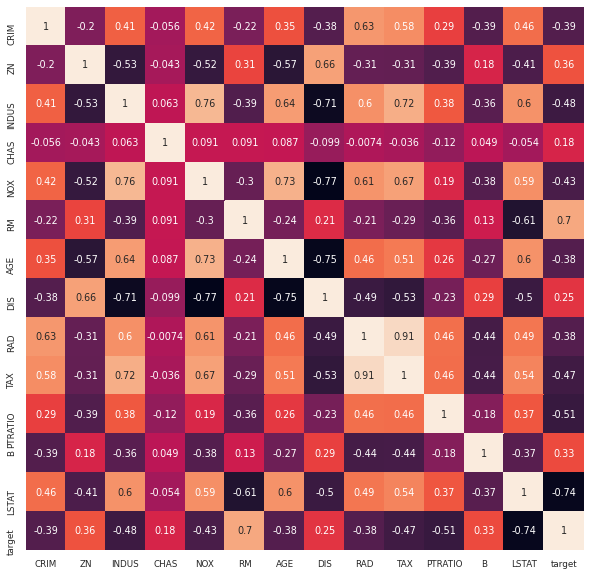

In [34]:
#---------------------------------------------------------------------------------------------------------데이터 탐색-------------------------------------------------------------------------------------------------------
#housing 의 data키를 이용하여 피처(설명 변수)데이터를 가져와 데이터 프레임으로 변환한다.
#피처 이름이 들어 있는 배열을 데이터프레임의 열 이름 으로 지정한다.
data = pd.DataFrame(housing['data'], columns=housing['feature_names'])
target = pd.DataFrame(housing['target'], columns=['target'])

#데이터셋 크기 
print(data.shape)
print(target.shape)

#concat 함수를 이용하여 target 데이터 셋을 data프레임 전체에 결합한다.
df = pd.concat([data, target], axis = 1)
df.head(1)

#info함수를 이용하여 데이터프레임의 기본 정보를 확인한다.
df.info()

#데이터 프레임의 데이터중 결측값이 없는지 확인한다.
df.isnull().sum()

#판다스의 corr 메소드를 이용하여 데이터프레임의 데이터의 상관 관계를 파악 후 시본의 heatmap을 이용하여 상관 관계를 시각화 한다.
df_corr = df.corr()

plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(df_corr, annot=True, cbar= False);
plt.show

#Target열과 상관 계수가 높은 순서대로 열 이름과 상관 계수를 출련한다.
#행 기준으로 Target을 제외한 나머지 모든 변수를 선택하고, 열 기준으로 Target을 선택한다.
#abs메소드를 이용하여 상관 계수의 값을 모두 양의 값으로 바꾼다.
#sort_values 메소드에 ascending = False 옵션을 설정하여 상관 계수 값을 내림차순으로 출력한다.

corr_order = df.corr().loc[:'LSTAT', 'target'].abs().sort_values(ascending=False)
corr_order

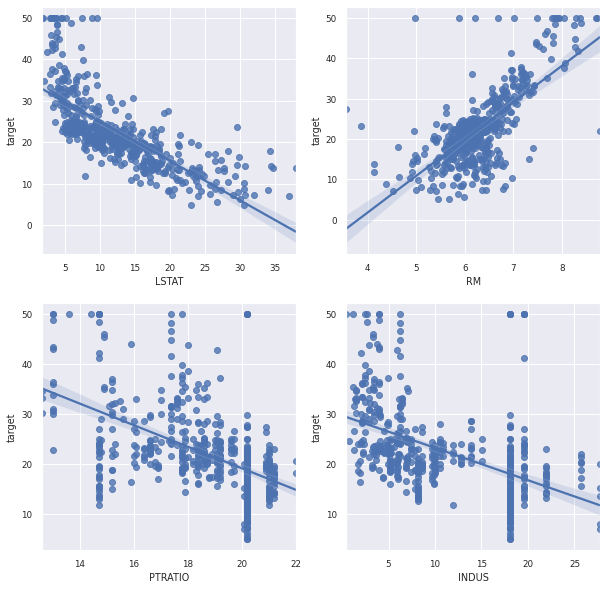

In [35]:
#데이터프레임의 특성을 위의 작업을 통해 확인했다면 상관 계수가 높은 특징을 이용한 그래프를 통해 데이터의 분포를 확인한다.
plot_cols = ['target','LSTAT','RM','PTRATIO','INDUS']
plot_df = df.loc[:, plot_cols]
plot_df.head()

#시본의 regplot 함수를 이용하여 선형 회귀선의 산점도에 분포를 표시한다.
plt.figure(figsize=(10,10))
for idx,col in enumerate(plot_cols[1:]):
  ax1 = plt.subplot(2,2,idx+1)
  sns.regplot(x=col, y=plot_cols[0], data=plot_df, ax=ax1)
plt.show()

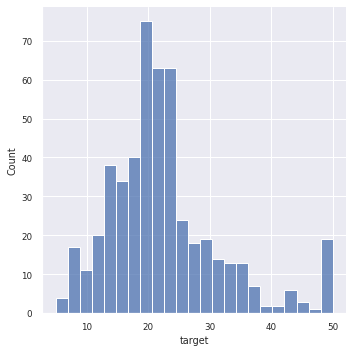

In [36]:
#목표 target의 분포를 알기 위해 displot함수를 이용히여 그린다.
sns.displot(x='target',kind='hist',data=df)
plt.show()

In [37]:
#---------------------------------------------------------------------------------------------------------데이터 전처리-------------------------------------------------------------------------------------------------------
#각 피처(열)의 데이터 크기에 따른 상대적 영향력의 차이를 제거하기 위해 피처의 크기를 비슷한 수준으로 맞춰주는 작업(피처 스케일링)이 필요하다.
#MinMaxScaler를 이용하여 피처 스케일링함
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_scaled = df.iloc[:,:-1]
scaler.fit(df_scaled)
df_scaled = scaler.transform(df_scaled)

df.iloc[:,:-1] = df_scaled[:,:]
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.000000,0.18,0.067815,0.0,0.314815,0.577505,0.641607,0.269203,0.000000,0.208015,0.287234,1.000000,0.089680,24.0
1,0.000236,0.00,0.242302,0.0,0.172840,0.547998,0.782698,0.348962,0.043478,0.104962,0.553191,1.000000,0.204470,21.6
2,0.000236,0.00,0.242302,0.0,0.172840,0.694386,0.599382,0.348962,0.043478,0.104962,0.553191,0.989737,0.063466,34.7
3,0.000293,0.00,0.063050,0.0,0.150206,0.658555,0.441813,0.448545,0.086957,0.066794,0.648936,0.994276,0.033389,33.4
4,0.000705,0.00,0.063050,0.0,0.150206,0.687105,0.528321,0.448545,0.086957,0.066794,0.648936,1.000000,0.099338,36.2


In [38]:
#데이터프레임의 데이터를 학습용 데이터와 검증용 데이터로 분할한다.
from sklearn.model_selection import train_test_split
x_data = df.loc[:, ['LSTAT','RM']]
y_data = df.loc[:,'target']
x_train,x_test,y_train,y_test = train_test_split(x_data,y_data,test_size = 0.2, shuffle = True, random_state =12)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(404, 2) (404,)
(102, 2) (102,)


In [39]:
#LinearRegression을 통한 target과 다른 특징들간의 회귀 결과
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)

print("회귀 계수(기울기) : ", np.round(lr.coef_, 1))
print("상수항(절편) : ", np.round(lr.intercept_, 1))

#LSTAT(저소득층 비율)의 결과 값은 -23.2이고 RM(방의 개수)의 결과 값은 25.4를 통해 알 수 있듯이 저소득의 비율이 클 수록 주택 가격은 내려가고 방의 개수가 늘수록 주택 가격은 올라 간다.

회귀 계수(기울기) :  [-23.2  25.4]
상수항(절편) :  16.3


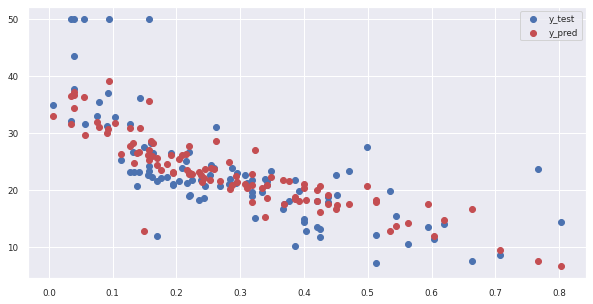

In [40]:
y_test_pred = lr.predict(x_test)

plt.figure(figsize=(10,5))
plt.scatter(x_test['LSTAT'],y_test, label='y_test')
plt.scatter(x_test['LSTAT'],y_test_pred, c='r', label='y_pred')
plt.legend(loc='best')
plt.show()

In [29]:
#잔차(residuals) -> 예측값과 실제값의 차이 값
#회귀의 전차를 구하는 방식은 여러 방식이 있다.
#MAE(Mean Absolute Error) : 실제값과 예측값의 차이의 절대 값의 평균낸 값
#MSE(Mean Squared Error) : 실제값과 예측값의 차이 즉 잔차의 제곱을 평균낸 값
#RMSE(Root Mean Squard Error) : MSE의 제곱근

In [41]:
#MSE를 통한 잔차 계산
from sklearn.metrics import mean_squared_error
y_train_pred = lr.predict(x_train)

train_mse = mean_squared_error(y_train, y_train_pred)
print("Train MSE : %.4f" %train_mse)

test_mse = mean_squared_error(y_test, y_test_pred)
print("Test MSE : %.4f" %test_mse)


Train MSE : 30.8042
Test MSE : 29.5065


In [42]:
#k-fold를 통해 교차 검증
from sklearn.model_selection import cross_val_score
lr = LinearRegression()
mse_scores = -1*cross_val_score(lr, x_train, y_train,cv=5, scoring = 'neg_mean_squared_error')

print("개별 Fold의 MSE : ", np.round(mse_scores, 4))
print("평균 MSE : %.3f" %np.mean(mse_scores))

개별 Fold의 MSE :  [31.465  34.668  28.9147 29.3535 34.6627]
평균 MSE : 31.813


In [48]:
#1차항으로 이루어진 함수식은 복잡한 데이터를 예측하기 어려움
#단항식을 다항식으로 만들기(예측력을 높일 수 있다.)
#PolynomialFeatures함수의 degree 옵션을 2차로 지정하고 데이터를 입력하면 데이터 셋을 2차 함수식으로 만들어줌
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree = 2)
x_train_poly  = pf.fit_transform(x_train)
print("원본 학습 데이터셋 : ", x_train.shape)
print("2차 다항식 변환 데이터셋 : ", x_train_poly.shape)


원본 학습 데이터셋 :  (404, 2)
2차 다항식 변환 데이터셋 :  (404, 6)


In [49]:
lr  = LinearRegression()
lr.fit(x_train_poly, y_train)

y_train_pred  = lr.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Poly Train MSE : %.4f" %train_mse)

x_test_poly = pf.fit_transform(x_test)
y_test_pred = lr.predict(x_test_poly)

test_mse = mean_squared_error(y_test, y_test_pred)
print("Poly Test MSE : %.4f" %test_mse)



Poly Train MSE : 21.5463
Poly Test MSE : 16.7954


In [52]:
#15차 다항식 변환 데이터셋으로 선형 회귀 모형 학습

pf = PolynomialFeatures(degree=15)
x_train_poly = pf.fit_transform(x_train)

lr =  LinearRegression()
lr.fit(x_train_poly, y_train)

y_train_pred = lr.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("15차항 Train MSE : %.4f" %train_mse)


x_test_poly = pf.transform(x_test)
y_test_pred = lr.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("15차항 Test MSE : %.4f" %test_mse)

15차항 Train MSE : 11.1589
15차항 Test MSE : 108504063264728.0625


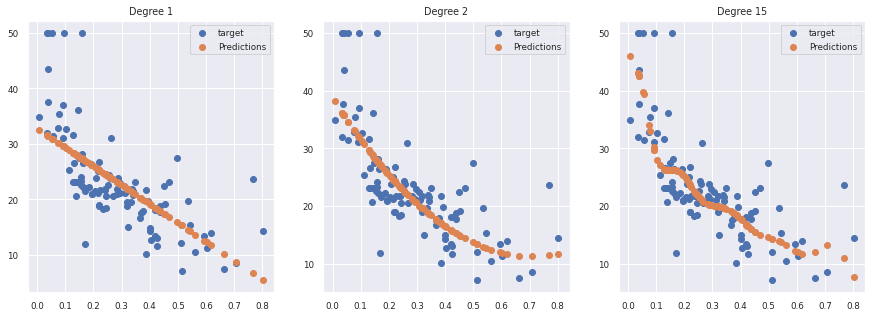

In [56]:
#다항식을 그래프로 그려 산점도 보여보기

plt.figure(figsize = (15,5))
for n, deg in enumerate([1,2,15]):
  ax1 = plt.subplot(1,3,n+1)

  pf = PolynomialFeatures(degree= deg)
  x_train_poly = pf.fit_transform(x_train.loc[:,['LSTAT']])
  x_test_poly = pf.fit_transform(x_test.loc[:,['LSTAT']])
  lr  = LinearRegression()
  lr.fit(x_train_poly, y_train)
  y_test_pred = lr.predict(x_test_poly)


  #실제값 분포
  plt.scatter(x_test.loc[:,['LSTAT']],y_test, label='target')
  #예측값 분포
  plt.scatter(x_test.loc[:,['LSTAT']],y_test_pred, label='Predictions')
  #제목 표시
  plt.title("Degree %d" %deg)
  #범례 표시
  plt.legend()
plt.show()

In [57]:
#모델의 복잡성을 낮추면서 과대적합을 억제하는 방법
#모델을 설명하는 각 피처가 모델의 예측 결과에 미치는 영향력을 가중치(회귀 계수)로 표현하는데, 이런 가중치들이 커지면 페널티를 부여하여 가중치를 낮은 수준으로 유지하는 방법이다.
#예측 편차를 줄이는 효과를 얻는다.
#이런 방법을 Regularization(규제)라고 부른다.


#l2규제와 l1규제가 있다.
#l2규제란 모델의 가중치의 제곱합에 페널티를 부여한다.
#l1규제란 가중치 절대값의 합에 페널티를 부옇나다.

In [61]:
#l2규제는 Ridge모델로 구현하며 apoha값으로 l2규제 강도를 조절한다.
#알파값을 증가시키면 규제 강도가 커지고 모델의 가중치를 감소시킨다.

from sklearn.linear_model import Ridge
rdg = Ridge(alpha = 2.5)
rdg.fit(x_train_poly, y_train)

y_train_pred = rdg.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("l2규제 Train MSE : %.4f" %train_mse)

y_test_pred = rdg.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("l2규제 Test MSE : %.4f" %test_mse)

l2규제 Train MSE : 35.9484
l2규제 Test MSE : 42.0011


In [63]:
#l1규제는 Lasso모델로 구현한다.
from sklearn.linear_model import Lasso
las = Lasso(alpha = 2.5)
las.fit(x_train_poly, y_train)

y_train_pred = las.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("l1 Train MSE : %.4f" %train_mse)

y_test_pred = las.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("l1 Test MSE : %.4f" %test_mse)

l1 Train MSE : 85.0053
l1 Test MSE : 82.1977


In [65]:
#Elastic 알고리즘을 통한 l2규제와 l1규제 같이 사용하기
#Elastic alpha는 l2규제와 l1 규제 강도의 합을 나타낸다.
#l1_ratio 옵션은 l1규제 강도의 상대적 이율을 조정하며, 1이면 l1규제와 같고 0이면 l2규제와 같다.

from sklearn.linear_model import ElasticNet
ela  = ElasticNet(alpha = 0.01, l1_ratio= 0.7)
ela.fit(x_train_poly, y_train)

y_train_pred = ela.predict(x_train_poly)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Ela Train MSE : %.4f" %train_mse)

y_test_pred = ela.predict(x_test_poly)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Ela Test MSE : %.4f" %test_mse)

Ela Train MSE : 33.7551
Ela Test MSE : 39.4968


In [71]:
#트리 기반의 회귀 분석

from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth = 3, random_state =12)
dtr.fit(x_train, y_train)

y_train_pred = dtr.predict(x_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("의사결정나무 Train MSE : %.4f" %train_mse)

y_test_pred = dtr.predict(x_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("의사결정나무 Test MSE : %.4f" %test_mse)


의사결정나무 Train MSE : 18.8029
의사결정나무 Test MSE : 17.9065


In [72]:
#랜덤포레스트 회귀 분석
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(max_depth = 3, random_state =12)
rfr.fit(x_train, y_train)

y_train_pred = rfr.predict(x_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("랜덤포레스트 Train MSE : %.4f" %train_mse)

y_test_pred = rfr.predict(x_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("랜덤포레스트 Test MSE : %.4f" %test_mse)

랜덤포레스트 Train MSE : 16.0201
랜덤포레스트 Test MSE : 17.7751


In [73]:
#xgboost 회귀 분석
from xgboost import XGBRegressor
xgrb = XGBRegressor(objective='reg:squarederror', max_depth = 3, random_state =12)
xgrb.fit(x_train, y_train)

y_train_pred = xgrb.predict(x_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("xgboost Train MSE : %.4f" %train_mse)

y_test_pred = xgrb.predict(x_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print("xgboost Test MSE : %.4f" %test_mse)

xgboost Train MSE : 8.2326
xgboost Test MSE : 18.0318
